\begin{align*}
\text{Maximise:} \quad & f(x_1, x_2) = 3x_1 + 2x_2\\
\text{Subject to:} \quad
& 4x_1 + 3x_2 \leq 17 \\
& 2x_1 + 5x_2 \leq 14 \\
& x_1 \geq 0,\quad x_2 \geq 0\quad \\
& x_1, x_2 \in \mathbb{Z}
\end{align*}

In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.optimize import linprog
from pulp import LpMaximize, LpProblem, LpVariable, value
from kan import *


In [71]:
c = [-3, -2]
A = [[4, 3], [2, 5]]
b = [17, 14]

lp_solution = linprog(c, A_ub=A, b_ub=b, bounds=[(0, None), (0, None)], method="highs")
x1LP, x2LP = lp_solution.x
print(f"Relaxed LP: x1 = {x1LP:.2f}, x2 = {x2LP:.2f}, Obj = {-lp_solution.fun:.2f}")

#using pulp for ILP
model = LpProblem(name="integer_lp", sense=LpMaximize)
x1 = LpVariable("x1", lowBound=0, cat="Integer")
x2 = LpVariable("x2", lowBound=0, cat="Integer")
model += 3*x1 + 2*x2
model += 4*x1 + 3*x2 <= 17
model += 2*x1 + 5*x2 <= 14
model.solve()
x1Int, x2Int = x1.varValue, x2.varValue
xAnalytical = [x1Int, x2Int]
objAnalytical = value(model.objective)
print(f"Integer Solution: x1 = {x1Int}, x2 = {x2Int}, Obj = {objAnalytical:.2f}")

Relaxed LP: x1 = 4.25, x2 = 0.00, Obj = 12.75
Integer Solution: x1 = 4.0, x2 = 0.0, Obj = 12.00


In [72]:
#generating samples

A = torch.tensor([[4, 3], [2, 5]], dtype=torch.float32)
b = torch.tensor([17, 14], dtype=torch.float32)

def objectiveFunction(x):
    return 3 * x[0] + 2 * x[1]

def constraint1(x): return 4 * x[0] + 3 * x[1] <= 17
def constraint2(x): return 2 * x[0] + 5 * x[1] <= 14
def nonNegativity(x): return (x[0] >= 0) & (x[1] >= 0)

def generateFeasibleSamples(nSamples=1000, xRange=(0, 10)):
    samples = []
    for _ in range(nSamples * 2):
        x1 = np.random.randint(xRange[0], xRange[1] + 1)
        x2 = np.random.randint(xRange[0], xRange[1] + 1)
        x = torch.tensor([x1, x2], dtype=torch.float32)
        if constraint1(x) and constraint2(x) and nonNegativity(x):
            samples.append(x)
        if len(samples) >= nSamples:
            break

    data = torch.stack(samples)
    targets = objectiveFunction(data)

    return data, targets

In [78]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.fc(x)

# Training settings
mlpNRuns = 5
mlpEpochs = 20000
learningRate = 0.01
mlpAllLosses = []
mlpObjectives, mlpLosses = [], []
lossCurves = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for run in range(mlpNRuns):
    torch.manual_seed(run)

    # Generate training data
    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = (yTrain - yTrain.mean()) / yTrain.std()
    yTrain = yTrain.unsqueeze(1)

    mlpModel = MLP()
    optimiser = optim.AdamW(mlpModel.parameters(), lr=learningRate)

    mlpRunLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []

    mlpStartTime = time.time()

    for epoch in range(mlpEpochs):
        mlpModel.train()
        optimiser.zero_grad()
        predictions = mlpModel(xTrain)
        mseLoss = torch.mean((predictions - yTrain.squeeze()) ** 2)
        feasPenalty = torch.mean(torch.clamp(A @ xTrain.T - b[:, None], min=0))

        #combine loss
        loss = mseLoss - 0.1 * predictions.mean() + feasPenalty
        loss.backward()
        optimiser.step()
        mlpRunLosses.append(loss.item())

        with torch.no_grad():
            mlpModel.eval()
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            bestX = xTrain[bestPrediction]
            mlpRunCoordinates.append(bestX)
            mlpBestVal = objectiveFunction(bestX).item()
            mlpBestX1 = bestX[0].item()
            mlpBestX2 = bestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    mlpAllLosses.append(mlpRunLosses)
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)        
    mlpEndTime = time.time()

    print(f"Run {run + 1}: Best x1 = {bestX[0].item():.0f}, x2 = {bestX[1].item():.0f} → Objective = {mlpBestVal:.2f}")
    
    mlpObjectives.append(mlpBestVal)
    mlpLosses.append(mlpRunLosses[-1])
    lossCurves.append(mlpRunLosses)
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": mlpRunLosses[-1],
        "time": mlpEndTime - mlpStartTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2
    })

#extracting metrics
mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} +- {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} +- {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s +- {np.std(mlpTimes):.4f}s")



Run 1: Best x1 = 4, x2 = 0 → Objective = 12.00
Run 2: Best x1 = 2, x2 = 0 → Objective = 6.00
Run 3: Best x1 = 2, x2 = 0 → Objective = 6.00
Run 4: Best x1 = 0, x2 = 2 → Objective = 4.00
Run 5: Best x1 = 1, x2 = 0 → Objective = 3.00
Mean Objective Value: 6.2000 +- 3.1241
Mean Final Loss:      0.4975 +- 0.0000
Mean Time:            77.4689s +- 17.7606s


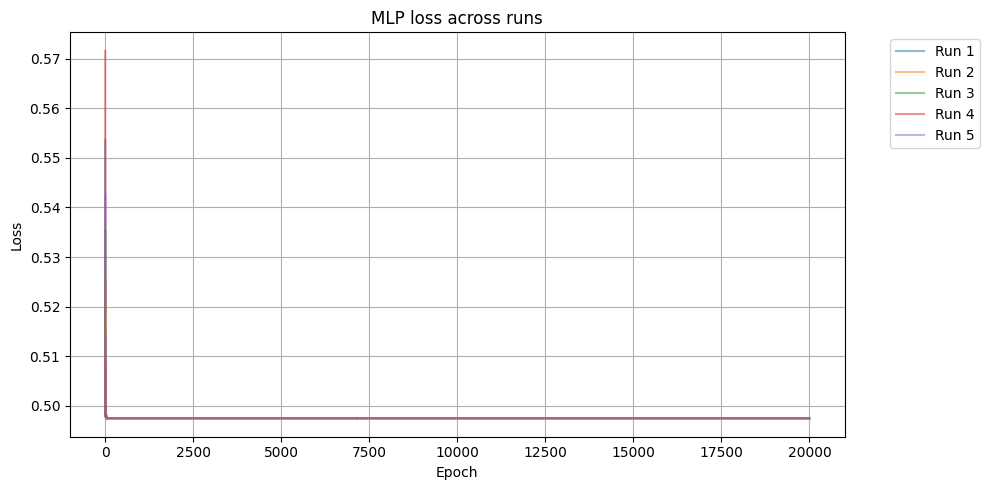

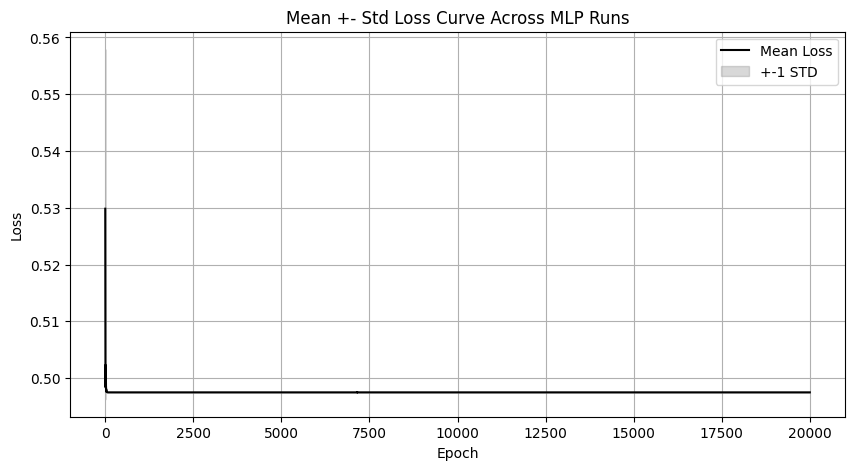

In [79]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP loss across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#stability metrics
mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and std of loss
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(mlpEpochs), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

#mlpModel
#mlpObjectives
#mlpLosses
#mlpTimes
#mlpAllLosses
#mlpMeanLoss
#mlpStdLoss
#mlpX1Vals
#mlpX2Vals

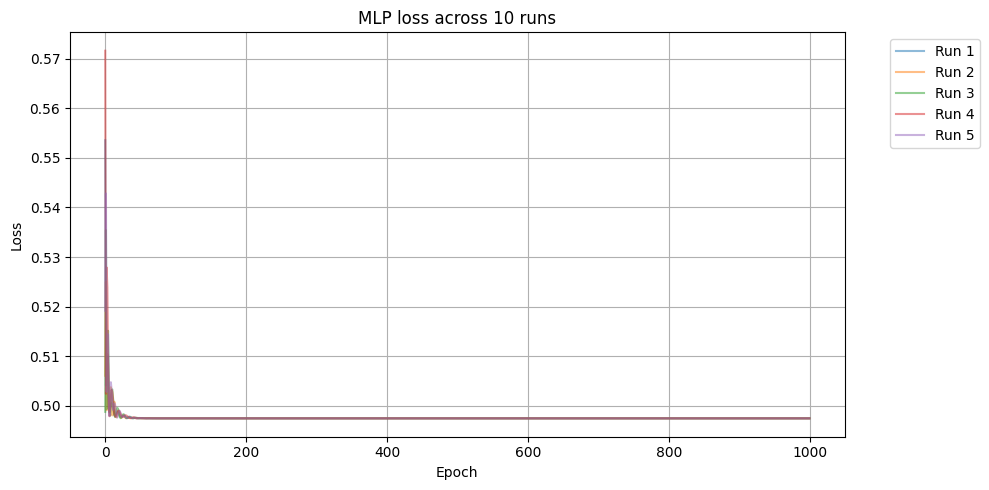

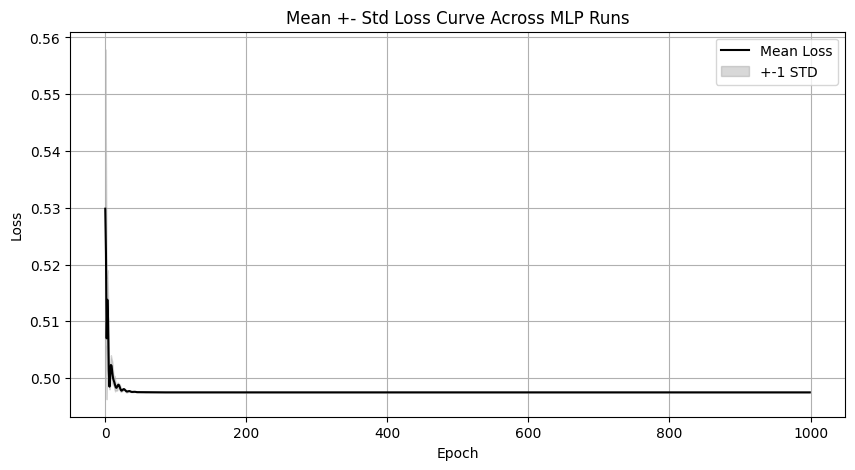

In [80]:
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP loss across 10 runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss[:1000], label="Mean Loss", color='black')
plt.fill_between(range(1000), mlpMeanLoss[:1000] - mlpStdLoss[:1000], mlpMeanLoss[:1000] + mlpStdLoss[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

[[4.4721360206604, 4.4721360206604, 4.4721360206604, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.8284270763397217, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.

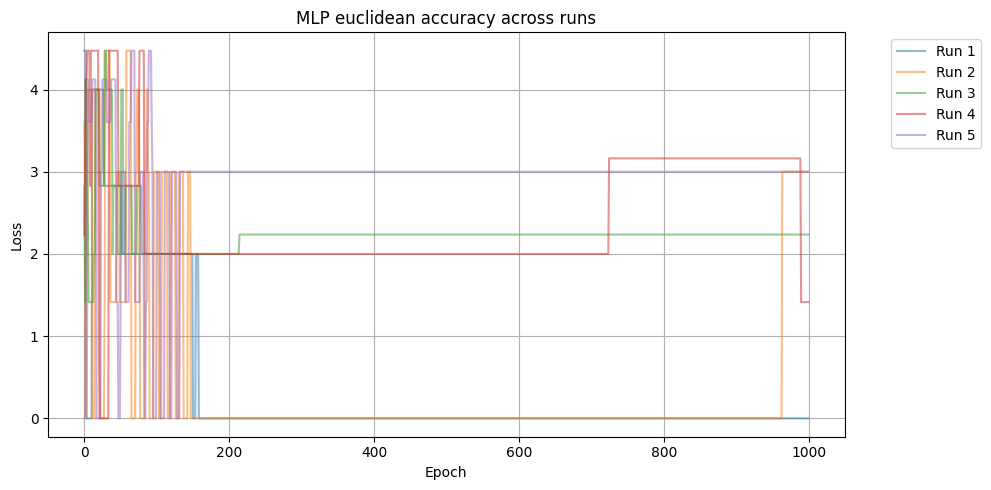

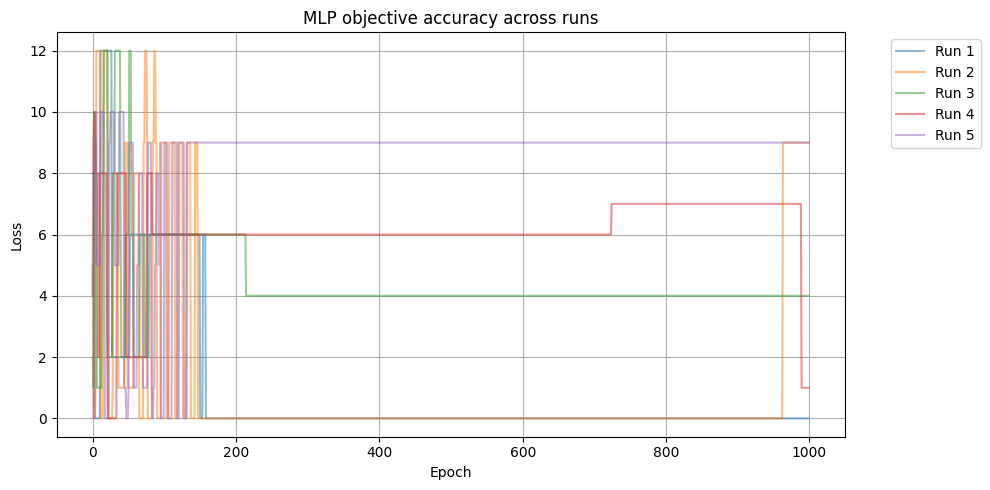

In [81]:
#euclidean accuracy over all runs
print(mlpAllEuclideanAccuracies)
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP euclidean accuracy across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#objective accuracy over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP objective accuracy across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


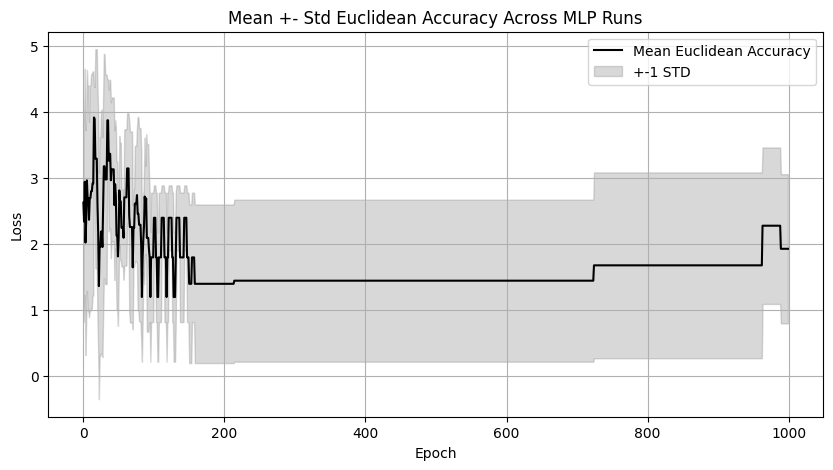

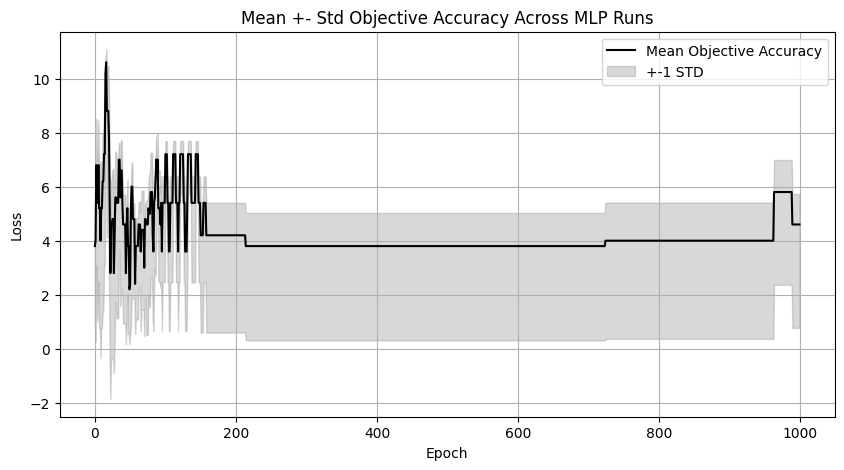

In [82]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean Euclidean Accuracy", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of objective accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean Objective Accuracy", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

In [84]:
kanNRuns = 5
kanEpochs = 1000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

for i in range(kanNRuns):
    torch.manual_seed(i)
    np.random.seed(i)

    # Generate training data
    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = yTrain.unsqueeze(1)

    # Initialize KAN model and optimizer
    kanModel = KAN(width=[2, 4, 4, 1], grid=3, k=3, seed=i+4)
    optimiser = optim.Adam(kanModel.parameters(), lr=0.001)

    runLosses = []
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []
    startTime = time.time()

    for epoch in range(kanEpochs):
        if epoch == 500:
            kanModel.refine(10)
        kanModel.train()
        optimiser.zero_grad()

        predictions = kanModel(xTrain)
        mseLoss = torch.mean((predictions - yTrain.squeeze()) ** 2)
        integerPenalty = torch.mean(torch.abs(predictions - torch.round(predictions)))
        feasibilityPenalty = torch.mean(torch.clamp(A @ xTrain.T - b[:, None], min=0))
        #loss = mseLoss - 0.1 * predictions.mean() + 1 * integerPenalty + feasibilityPenalty
        loss = torch.mean((predictions - yTrain.squeeze())**2) + 10 * integerPenalty

        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())
    
        with torch.no_grad():
            kanModel.eval()
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            kanBestX = xTrain[bestPrediction]
            kanRunCoordinates.append(kanBestX)
            bestVal = objectiveFunction(kanBestX).item()
            kanBestX1 = kanBestX[0].item()
            kanBestX2 = kanBestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([kanBestX1, kanBestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    kanAllLosses.append(runLosses)
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": kanBestX1,
        "x2": kanBestX2
    })

    print(f"Run {i+1}: Best x1 = {kanBestX1:.4f}, x2 = {kanBestX2:.4f} → Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")
#metrics
kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")


checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 1: Best x1 = 3.0000, x2 = 1.0000 → Objective = 11.0000, Loss = 7.9912
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 2: Best x1 = 4.0000, x2 = 0.0000 → Objective = 12.0000, Loss = 2.0022
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 3: Best x1 = 3.0000, x2 = 1.0000 → Objective = 11.0000, Loss = 22.5291
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 4: Best x1 = 0.0000, x2 = 1.0000 → Objective = 2.0000, Loss = 10.0156
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 5: Best x1 = 4.0000, x2 = 0.0000 → Objective = 12.0000, Loss = 14.6587
Mean Objective Value: 9.6000 +- 3.8262
Mean Final Loss:      11.4394 +- 6.8750
Mean Time:            50.0450s +- 1.7459s


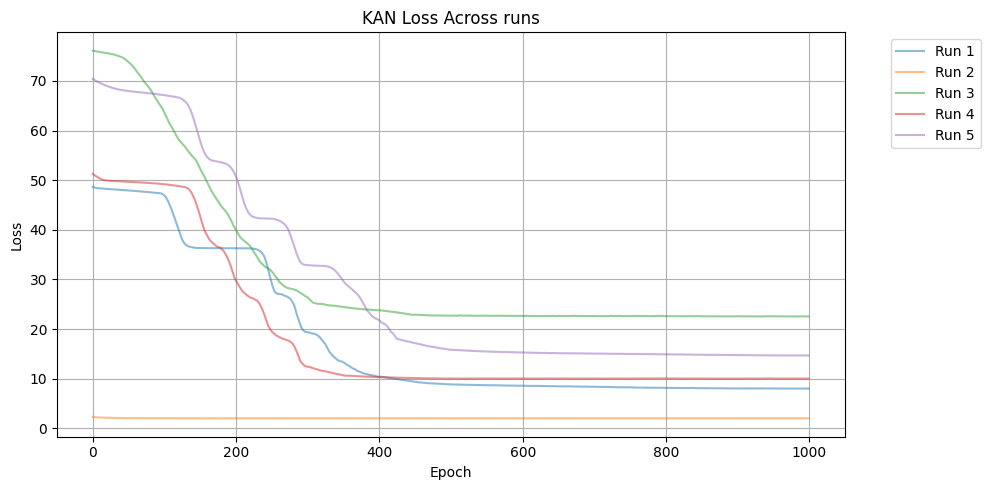

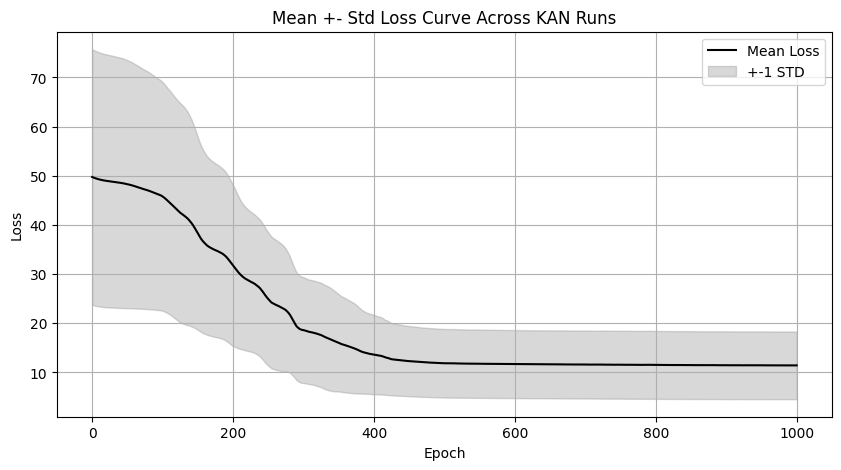

In [87]:
#loss curve
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("KAN Loss Across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(kanEpochs), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across KAN Runs")
plt.grid(True)
plt.legend()
plt.show()

#kanModel
#kanObjectives
#kanLosses
#kanTimes
#kanX1Vals
#kanX2Vals
#kanAllLosses
#kanMeanLoss
#kanStdLoss


[[4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 4.4721360206604, 3.605551242828369, 3.605551242828369, 3.605551242828369, 3.605551242828369, 3.605551242828369, 3.

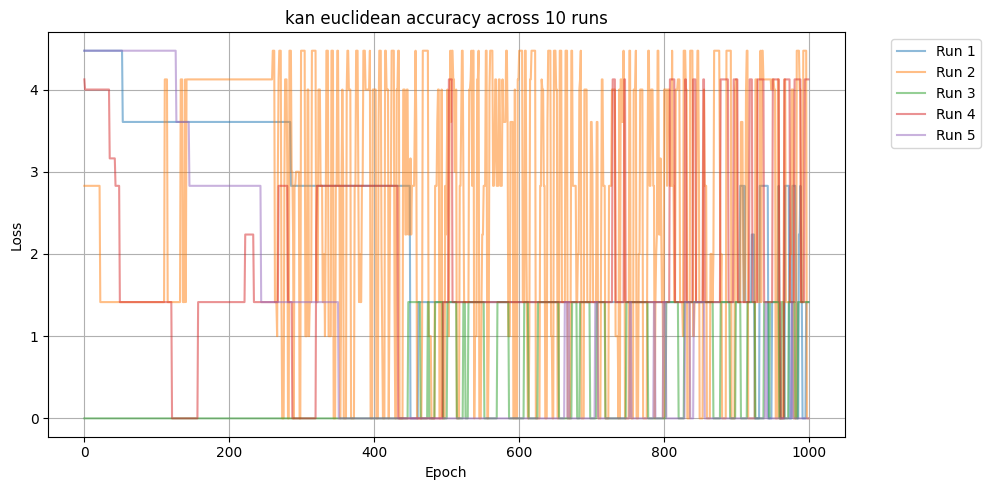

[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0

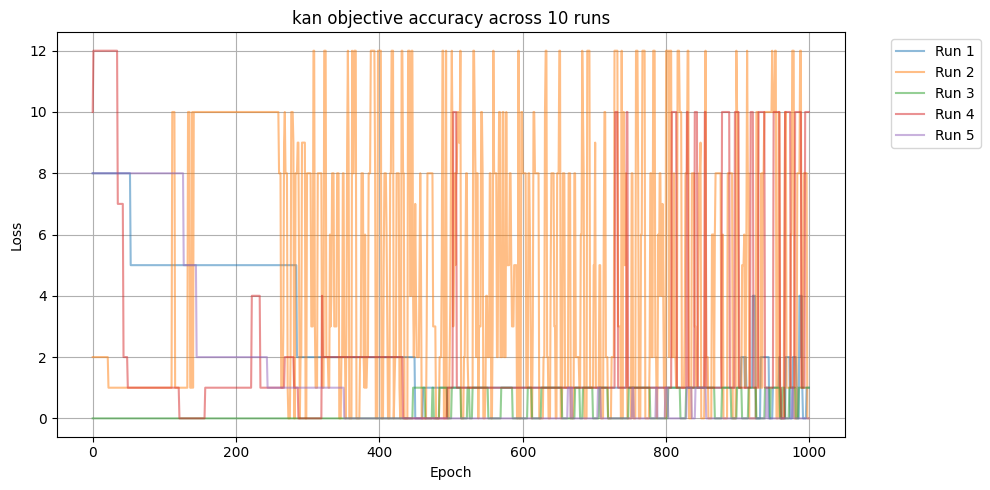

In [88]:
#kan euclidean accuracy across all runs
print(kanAllEuclideanAccuracies)
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("kan euclidean accuracy across 10 runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#kan objective accuracy across all runs
print(kanAllObjectiveAccuracies)
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("kan objective accuracy across 10 runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



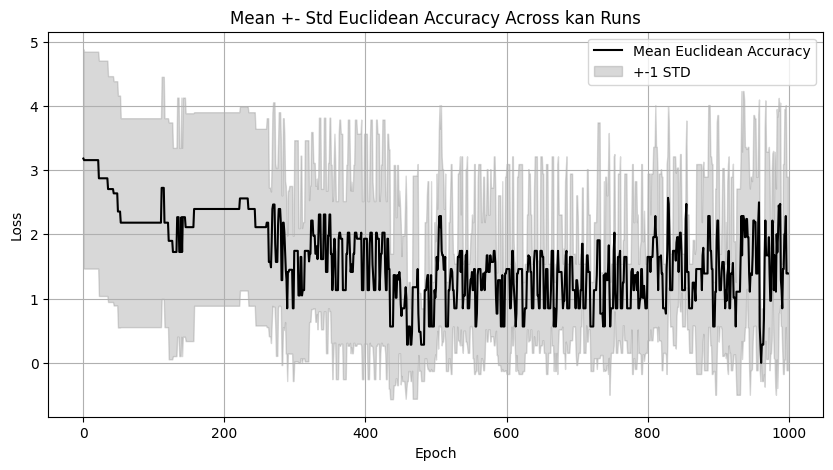

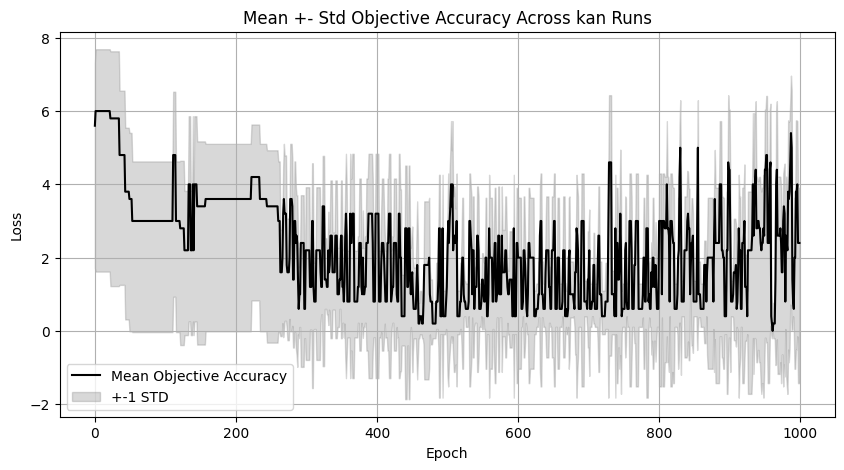

In [89]:
#kan mean and std of euclidean accuracy
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy, label="Mean Euclidean Accuracy", color='black')
plt.fill_between(range(kanEpochs), kanMeanEuclideanAccuracy - kanStdEuclideanAccuracy, kanMeanEuclideanAccuracy + kanStdEuclideanAccuracy,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across kan Runs")
plt.grid(True)
plt.legend()
plt.show()

#kan mean and std of objective accuracy
kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy, label="Mean Objective Accuracy", color='black')
plt.fill_between(range(kanEpochs), kanMeanObjectiveAccuracy - kanStdObjectiveAccuracy, kanMeanObjectiveAccuracy + kanStdEuclideanAccuracy,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across kan Runs")
plt.grid(True)
plt.legend()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [90]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [91]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = finalLoss * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if loss <= threshold:
                speeds.append(i)
                break
    return speeds

mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)



In [92]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,6.200000e+00,9.600000
1,Std Objective Value,3.124100e+00,3.826225
2,Best Objective Value,1.200000e+01,12.000000
3,Mean Final Loss,4.975001e-01,11.439359
4,Std Final Loss,7.679521e-08,6.874960
5,Mean Time (s),7.746887e+01,50.045006
6,Std Time (s),1.776060e+01,1.745881
7,Mean Convergence Epoch,4.000000e-01,410.200000
8,Std Convergence Epoch,4.898979e-01,223.938742
9,Model Parameters,1.185000e+03,528.000000


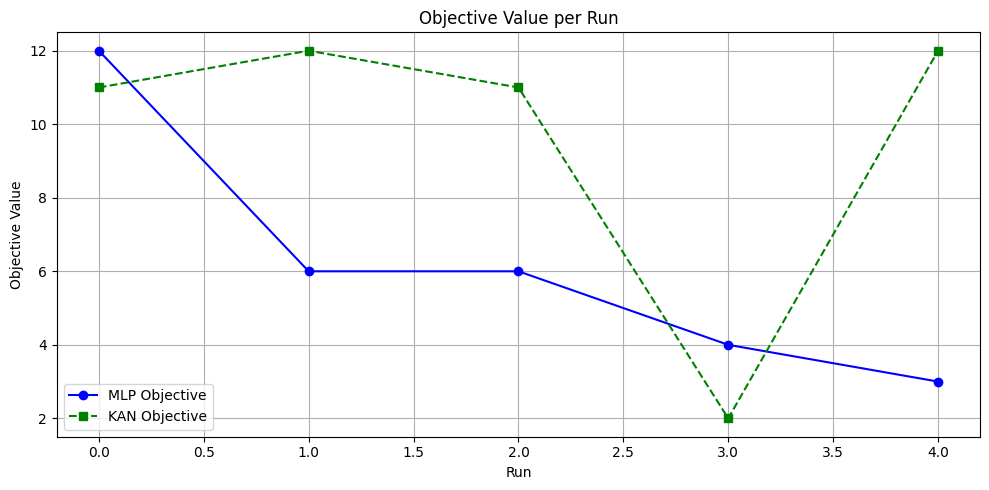

In [93]:
#objective value across models
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

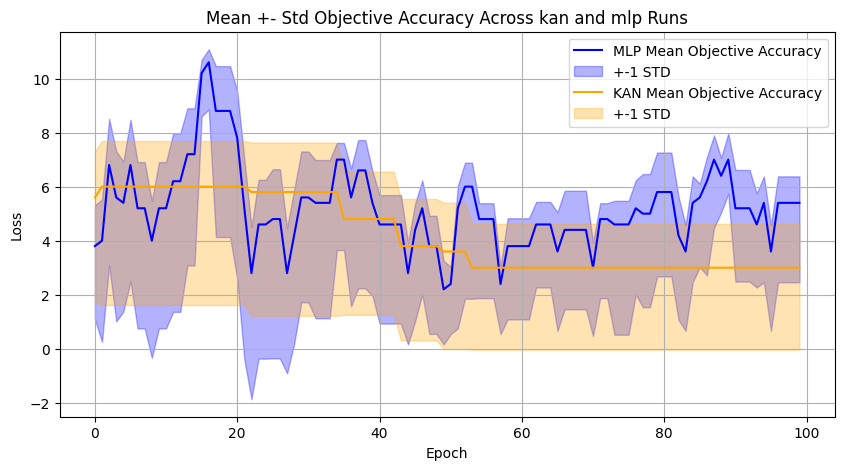

In [94]:
#objective accuracy comparison
epochLimit = 100
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:epochLimit], label="MLP Mean Objective Accuracy", color='blue')
plt.fill_between(range(epochLimit), mlpMeanObjectiveAccuracy[:epochLimit] - mlpStdObjectiveAccuracy[:epochLimit], mlpMeanObjectiveAccuracy[:epochLimit] + mlpStdEuclideanAccuracy[:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(kanMeanObjectiveAccuracy[:epochLimit], label="KAN Mean Objective Accuracy", color='orange')
plt.fill_between(range(epochLimit), kanMeanObjectiveAccuracy[:epochLimit] - kanStdObjectiveAccuracy[:epochLimit], kanMeanObjectiveAccuracy[:epochLimit] + kanStdEuclideanAccuracy[:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across kan and mlp Runs")
plt.grid(True)
plt.legend()
plt.show()

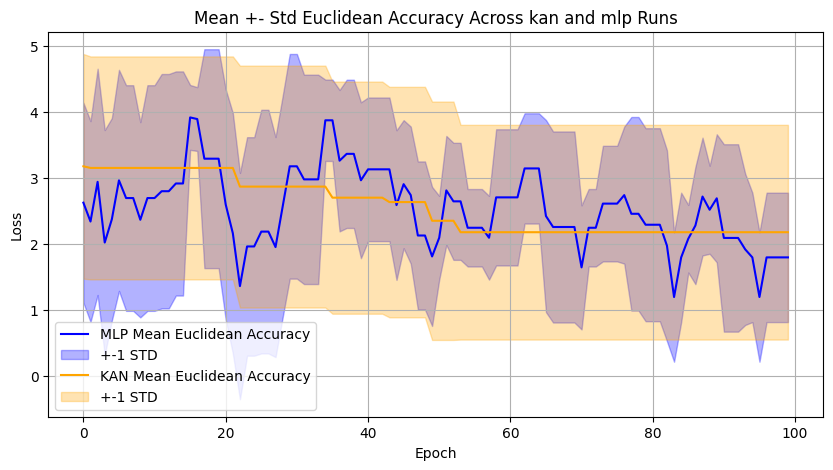

In [95]:
#euclidean accuracy comparison
epochLimit = 100
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:epochLimit], label="MLP Mean Euclidean Accuracy", color='blue')
plt.fill_between(range(epochLimit), mlpMeanEuclideanAccuracy[:epochLimit] - mlpStdEuclideanAccuracy[:epochLimit], mlpMeanEuclideanAccuracy[:epochLimit] + mlpStdEuclideanAccuracy[:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(kanMeanEuclideanAccuracy[:epochLimit], label="KAN Mean Euclidean Accuracy", color='orange')
plt.fill_between(range(epochLimit), kanMeanEuclideanAccuracy[:epochLimit] - kanStdEuclideanAccuracy[:epochLimit], kanMeanEuclideanAccuracy[:epochLimit] + kanStdEuclideanAccuracy[:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across kan and mlp Runs")
plt.grid(True)
plt.legend()
plt.show()

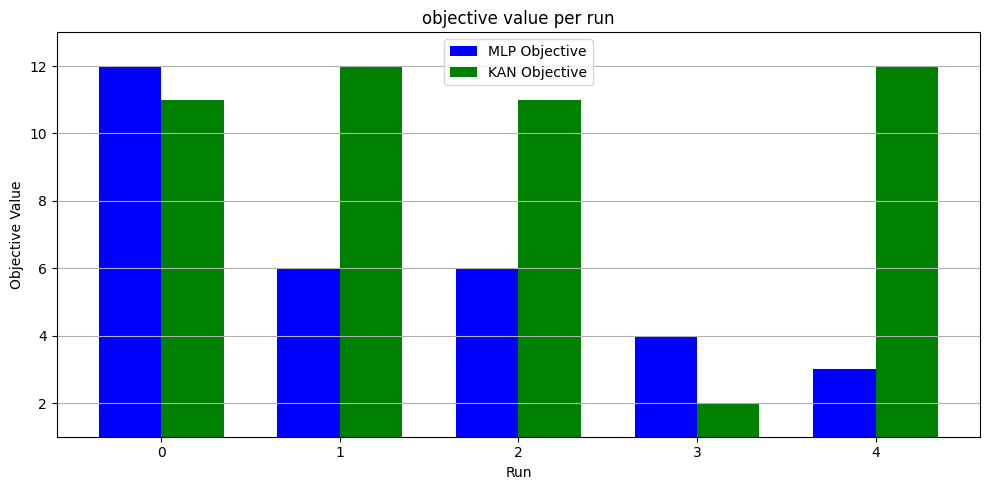

In [96]:
#bar chart comparison of objective values
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP Objective", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN Objective", color='green')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

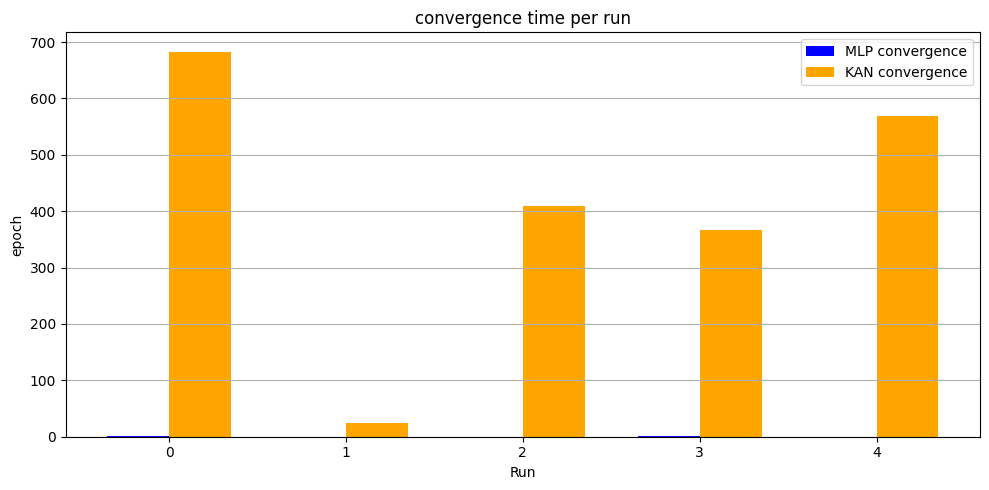

In [97]:
#convergence time comparison
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

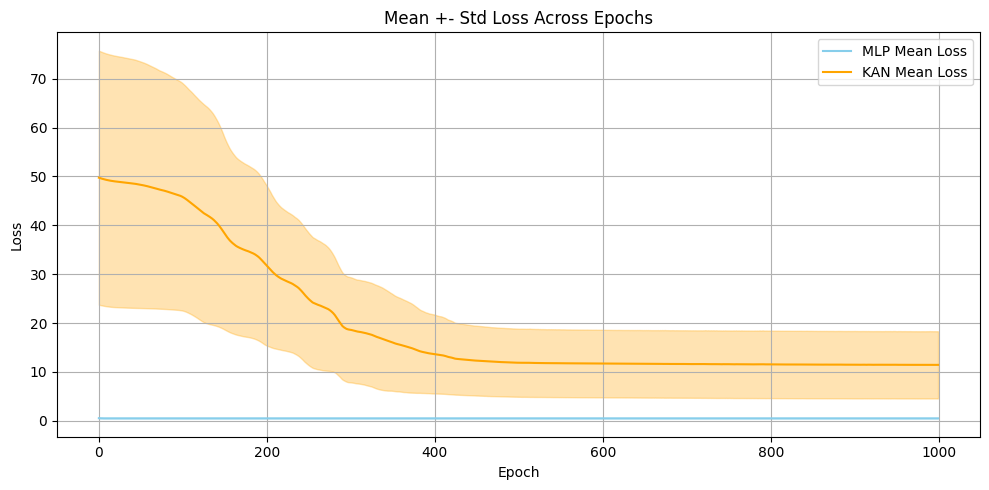

In [98]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:1000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:1000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN Mean Loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Across Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
mlpBestPrediction = np.argmax(mlpObjectives)
kanBestPrediction = np.argmax(kanObjectives)
mlpBestX1 = mlpX1Vals[mlpBestPrediction]
mlpBestX2 = mlpX2Vals[mlpBestPrediction]
kanBestX1 = kanX1Vals[kanBestPrediction]
kanBestX2 = kanX2Vals[kanBestPrediction]

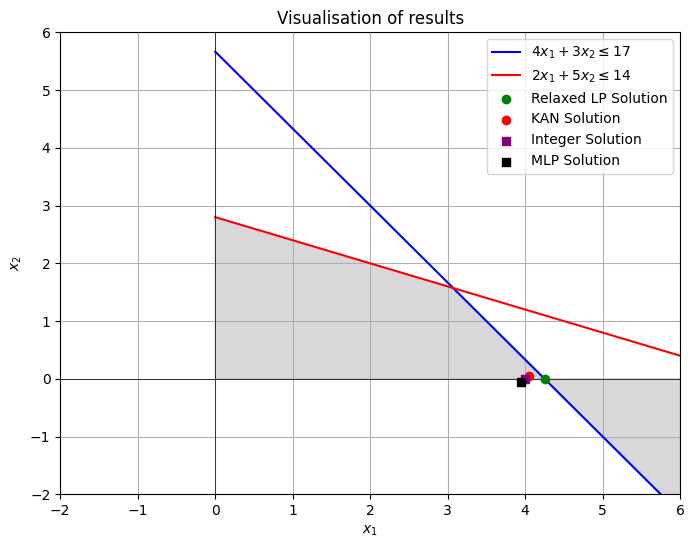

In [106]:
xVals = np.linspace(0, 10, 200)
y1Vals = (17 - 4*xVals) / 3
y2Vals = (14 - 2*xVals) / 5

offset = 0.05
# Plot feasible region
plt.figure(figsize=(8, 6))
plt.plot(xVals, y1Vals, label=r"$4x_1 + 3x_2 \leq 17$", color="blue")
plt.plot(xVals, y2Vals, label=r"$2x_1 + 5x_2 \leq 14$", color="red")
plt.fill_between(xVals, np.minimum(y1Vals, y2Vals), 0, color="gray", alpha=0.3)

# Plot solutions
plt.scatter(x1LP, x2LP, color="green", label="Relaxed LP Solution", zorder=3)
plt.scatter(kanBestX1+offset, kanBestX2+offset, color="red", label="KAN Solution", zorder=3)
plt.scatter(x1Int, x2Int, color="purple", label="Integer Solution", zorder=3, marker="s")
plt.scatter(mlpBestX1-offset, mlpBestX2-offset, color="black", label="MLP Solution", zorder=3, marker="s")

# Labels
plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.title("Visualisation of results")
plt.grid()
plt.show()

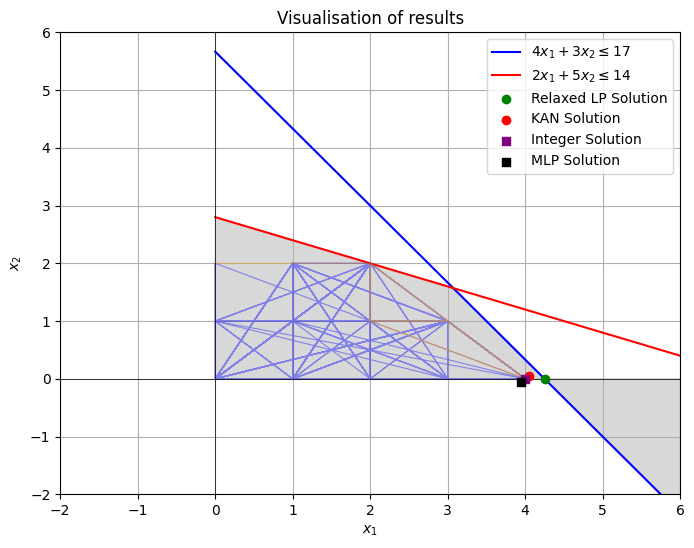

In [107]:
#same as above except we see the paths taken
xVals = np.linspace(0, 10, 200)
y1Vals = (17 - 4*xVals) / 3
y2Vals = (14 - 2*xVals) / 5

offset = 0.05
# Plot feasible region
plt.figure(figsize=(8, 6))
plt.plot(xVals, y1Vals, label=r"$4x_1 + 3x_2 \leq 17$", color="blue")
plt.plot(xVals, y2Vals, label=r"$2x_1 + 5x_2 \leq 14$", color="red")
plt.fill_between(xVals, np.minimum(y1Vals, y2Vals), 0, color="gray", alpha=0.3)
#mlp path taken
for runCoords in mlpAllCoordinates[:1]:
    runCoords = np.array(runCoords)
    plt.plot(runCoords[:,0],runCoords[:,1], alpha=0.4, color='blue', linewidth=0.8)

#kan path taken
for runCoords in kanAllCoordinates[:1]:
    runCoords = np.array(runCoords)  # Shape (epochs, 2)
    plt.plot(runCoords[:,0],runCoords[:,1], alpha=0.4, color='orange', linewidth=0.8)

# Plot solutions
plt.scatter(x1LP, x2LP, color="green", label="Relaxed LP Solution", zorder=3)
plt.scatter(kanBestX1+offset, kanBestX2+offset, color="red", label="KAN Solution", zorder=3)
plt.scatter(x1Int, x2Int, color="purple", label="Integer Solution", zorder=3, marker="s")
plt.scatter(mlpBestX1-offset, mlpBestX2-offset, color="black", label="MLP Solution", zorder=3, marker="s")

# Labels
plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.title("Visualisation of results")
plt.grid()
plt.show()